#### <br>
<center>
    <h1>Exercise Sheet 8</h1>
</center>
<br>

In this exercise, we would like to train an auto-encoder on the MNIST dataset. We consider the simple two-layer autoencoder network:

\begin{align*}
\boldsymbol{z}_i &= \max(0,V \boldsymbol{x}_i + \boldsymbol{b}) & \text{(layer 1)}\\
\hat{\boldsymbol{x}}_i &= W \boldsymbol{z}_i + \boldsymbol{a} & \text{(layer 2)}
\end{align*}

where $W,V$ are matrices of parameters of the encoder and the decoder, and $\boldsymbol{b},\boldsymbol{a}$ are additional bias parameters. We seek to optimize the objective:

\begin{align*}
\min_{W, V, \boldsymbol{b}, \boldsymbol{a}} ~~
\underbrace{ \frac1N \sum_{i=1}^N \| \boldsymbol{x}_i - \hat{\boldsymbol{x}}_i \|^2}_{\text{reconstruction}}
\end{align*}

The reconstruction term is the standard mean square error between the data points and their reconstructions.

# Load MNIST dataset
First, we load the MNIST dataset and display some example images which show the general distribution of the data. The dataset is built into torchvision which automatically downloads the data into the `data` directory.

/home/ssadiku/anaconda3/envs/pwsmooth_adversarialattacks/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


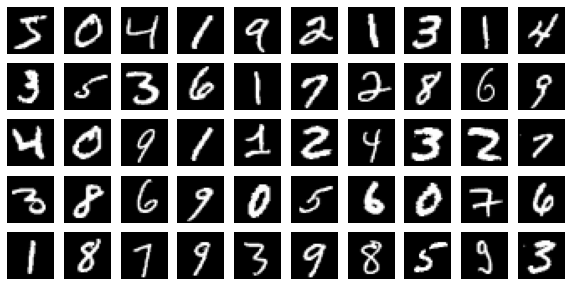

In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch

data_root = './data'
train_dataset = MNIST(data_root, train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(data_root, train=False, download=True, transform=T.ToTensor())

def show_samples(dataset):
    h, w = 5, 10
    fig, ax = plt.subplots(h, w)
    fig.set_size_inches((w, h))
    ax = ax.ravel()
    for i in range(h * w):
        img, label = dataset[i]
        ax[i].imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
        ax[i].axis('off')
    plt.show()

show_samples(train_dataset)

We can use a DataLoader together with the torchvision dataset which batches the data and can be used as an iterator.

In [2]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 1) Forward Pass (15P)

Please implement the forward pass of the network which receives a batch of image vectors $x \in \mathbb{R}^{N \times 784}$ and network parameters $V, W, b, a$ and returns the average reconstruction loss for one batch.

In [3]:
# import solution

def get_objective_term(x, V, W, b, a):
    # TODO: implement this function
    z = torch.max(torch.zeros(V.shape[1]), torch.mm(x, V)+b)
    x_rec = torch.mm(z, W) + a
    rec = torch.sum((x - x_rec) ** 2)
    
    return rec / x.shape[0]
    # TODO
    return solution.get_objective_term(x, V, W, b, a)

# Training Loop
The following method implements the training loop of the Autoencoder.

In [4]:
import torch.optim
import torch.nn
from tqdm.auto import tqdm
from dataclasses import dataclass

@dataclass
class Autoencoder:
    V: torch.nn.Parameter
    W: torch.nn.Parameter
    b: torch.nn.Parameter
    a: torch.nn.Parameter
        
    def params(self):
        return {'V': self.V, 'W': self.W, 'b': self.b, 'a': self.a}
    
def train(loader, h=32, epochs=5):
    torch.manual_seed(0)
    d = 28 * 28
    V = torch.nn.Parameter(d ** -.5 * torch.randn([d, h]))
    W = torch.nn.Parameter(torch.zeros([h, d]))
    b = torch.nn.Parameter(torch.zeros([h]))
    a = torch.nn.Parameter(torch.zeros([d]))
    optimizer = torch.optim.Adam((V, W, b, a), lr=0.0001)
    for epoch in range(epochs):
        for x, _ in loader:
            optimizer.zero_grad()
            x = x.reshape((-1, 28 * 28))
            loss = get_objective_term(x, V, W, b, a)
            loss.backward()
            optimizer.step()
        print('Epoch %3d %8.2f' % (epoch, loss.data))
    return Autoencoder(V=V, W=W, b=b, a=a)

In [5]:
# Train the Autoencoder and receive respective parameters with hidden dimension 32
ae = train(train_loader, h=32, epochs=5)

Epoch   0    27.89
Epoch   1    19.00
Epoch   2    14.07
Epoch   3    14.76
Epoch   4    13.09


# 2) Reconstruction (10P)
After the training, we want to see how good the model reconstructs the encoded example with the decoder.
Implement a method that reconstructs the image with the encoder given the parameters of the network. The method receives a batch of images $x \in \mathbb{R}^{N \times 784}$ and should output images $\in \mathbb{R}^{N \times 28 \times 28}$

In [6]:
# import solution
def reconstruct(x, V, W, b, a):
    # TODO: implement this function
    z = torch.max(torch.zeros(V.shape[1]), torch.mm(x, V) +b)
    x_rec = torch.mm(z, W) + a
    return x_rec.reshape(x.shape[0], 28, 28)
    # TODO
    x_rec = solution.reconstruct(x, V, W, b, a)
    return x_rec

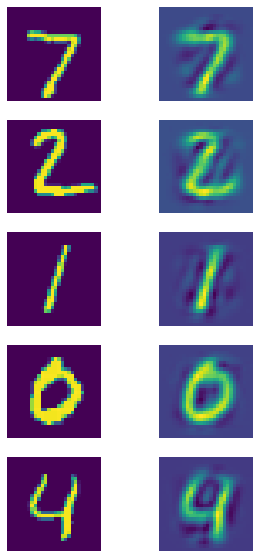

In [7]:
# encode and reconstruct some examples from the test set
num_images = 5
test_batch = next(iter(test_loader))[0][:num_images]
reconstructions = reconstruct(test_batch.reshape(num_images, 28 * 28), **ae.params()).detach()
fig, ax = plt.subplots(num_images, 2)
fig.set_size_inches(5, 10)
for i in range(num_images):
    ax[i][0].imshow(test_batch[i][0])
    ax[i][1].imshow(reconstructions[i])
    for a in ax[i]:
        a.axis('off')

We can see that we can still recover most of the digit details from the hidden representation.

## Anomaly Detection
Now we want to use an Autoencoder for anomaly detection. Given a set of normal data points, anomaly detection wants to assign a high anomaly score for samples that are in some way abnormal from the set of normal samples. In our example all zeros will be the normal data and all other digits will be anomalies. Therefore, we only train with the zeros.

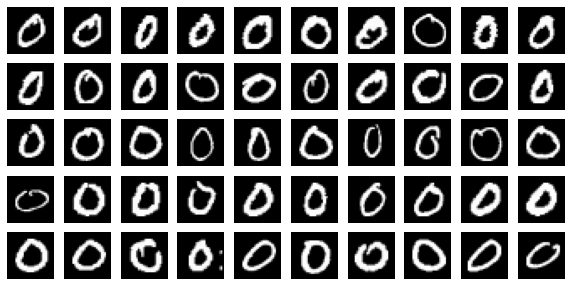

In [8]:
import copy 
from torch.utils.data import Subset 
import numpy as np

# Our training dataset only contains zeros.
normal_class = 0
one_class_train = Subset(dataset=copy.deepcopy(train_dataset), indices=np.where(train_dataset.targets == normal_class)[0])
show_samples(one_class_train)

In [9]:
# Train the autoencoder with only zeros.
train_one_class_loader = DataLoader(one_class_train, batch_size=64, shuffle=True)
# We increase number of epochs because the dataset is now smaller.
anomaly_ae = train(train_one_class_loader, h=32, epochs=20)

Epoch   0    48.78
Epoch   1    44.07
Epoch   2    40.70
Epoch   3    34.89
Epoch   4    29.79
Epoch   5    29.04
Epoch   6    28.04
Epoch   7    24.56
Epoch   8    24.82
Epoch   9    24.84
Epoch  10    20.79
Epoch  11    21.96
Epoch  12    19.79
Epoch  13    19.85
Epoch  14    16.88
Epoch  15    15.90
Epoch  16    18.63
Epoch  17    18.49
Epoch  18    16.06
Epoch  19    16.37


# 3) Anomaly Score (10P)
Given now the trained autoencoder, we want to assign each sample an anomaly score. By using your knowledge from the lecture, implement the anomaly score for a batch of samples x, given its reconstruction from the autoencoder. The function should return an array that holds an anomaly score for each sample of the batch.

In [10]:
# import solution
def anomaly_score(x, reconstruction):
    # TODO: implement this function
    return ((reconstruction - x) ** 2).sum(axis=-1)
    # TODO
    return solution.anomaly_score(x, reconstruction)

### Evaluating 
For all the samples from the test set, we compute the anomaly score. Then, we want to check how good the anomaly score seperates the normal samples from the anomalies. For that purpose, the `roc_auc_score` can be used. A larger score indicates that the normal samples can be better seperated from the anomalies. We also plot a histogram with the anomaly scores to visualize the separation.

AUC: 0.987775125571293


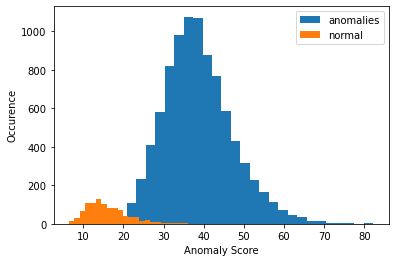

In [11]:
from sklearn.metrics import roc_auc_score

def compute_anomaly_scores(test_loader, V, W, b, a):
    anomaly_scores = []
    labels = []
    for x, y in test_loader:
        x = x.reshape(x.shape[0], 28 * 28)
        reconstruction = reconstruct(x, **anomaly_ae.params()).detach()
        batch_anomaly_scores = anomaly_score(x, reconstruction.reshape(x.shape[0], 28 * 28))
        # label 0 if sample is normal, otherwise 1
        batch_labels = (y != normal_class).numpy()
        anomaly_scores.append(batch_anomaly_scores)
        labels.append(batch_labels)
    anomaly_scores = np.concatenate(anomaly_scores)
    labels = np.concatenate(labels)
    return anomaly_scores, labels

test_loader = DataLoader(test_dataset, batch_size=64)
anomaly_scores, labels = compute_anomaly_scores(test_loader, **anomaly_ae.params())
score = roc_auc_score(labels, anomaly_scores)

print('AUC:', score)
for name, label in [('anomalies', 1), ('normal', 0)]:
    plt.hist(anomaly_scores[labels == label], bins=30, label=name)
plt.ylabel('Occurence')
plt.xlabel('Anomaly Score')
plt.legend()

We can see that the zero digit (normal data) and all other digits are well separated with the anomaly score.

## Anomaly Heatmaps
One advantage of the autoencoder anomaly detection method is that we can use the reconstructions as an anomaly heatmap. These show which parts could not be reconstructed well from the model. The code below plots for selected samples the reconstruction and the anomaly heatmap.

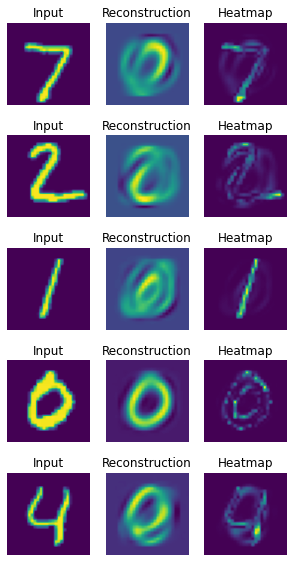

In [12]:
num_images = 5
test_loader = DataLoader(test_dataset, batch_size=num_images, shuffle=False)
test_batch = next(iter(test_loader))[0]
reconstructions = reconstruct(
        test_batch.reshape(num_images, 28 * 28), 
        **anomaly_ae.params()).detach()

fig, ax = plt.subplots(num_images, 3)
fig.set_size_inches(5, 10)
for i in range(num_images):
    ax[i][0].imshow(test_batch[i][0])
    ax[i][0].set_title('Input')
    ax[i][1].imshow((reconstructions[i]))
    ax[i][1].set_title('Reconstruction')
    ax[i][2].imshow((reconstructions[i] - test_batch[i][0]) ** 2)
    ax[i][2].set_title('Heatmap')
    for a in ax[i]:
        a.axis('off')